In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

%run ../global_variables.py ./
%run ../global_functions.py ./

This notebook allows individual runs for each dataset (parts 1 and 2) as well as the computation of the water budget for given datasets. 

# 1. Load data

Load the spatial grid where variables are available (`spatial_grid`).

`hydro_grid` is a DataFrame with each row representing a cell grid and each column is a month

`time_hydro` is the set of months when the current variable is known

- For precipitations (`'P'`) choose among : `'CPC'`, `'TRMM'`, `'GLDAS21'`, `'MERRA2'`, `'MSWEP'`

- For evapotranspiration (`'ET'`) choose among : `'GLDAS'`, `'SEB'`, `'GLDAS21_NOAH36'`, `'GLDAS21_CLSM25'`, `'GLDAS21_VIC412'`, `'MERRA2'`, `'SSEBop'`

- For runoff (`'R'`) choose among `'GLDAS'`, `'MERRA2'`, `'GLDAS21_NOAH36'`, `'GLDAS21_CLSM25'`, `'GLDAS21_VIC412'`, `'GRUN'`

- For water storage (`'TWS'`) choose among `'GRACE_JPL_mascons'`, `'GRACE_CSR_mascons'`, `'GRACE_CSR_grid'`

- For potential evapotranspiration (`'PET'`) choose among `'SSEBop'`, `'CRU'`

In [2]:
hydro_var_name='P'
data='GPCP'

(spatial_grid,hydro_grid,time_hydro)=load_hydro_data(hydro_var_name,data,
                            fill_value=dict_fill_value[data],version=version_data[data])

Load basins data : 
- `AREA` is the basin area in km^2

In [3]:
basins=load_basins_data()
basins

,AREA,CLIMATE,geometry
HYBAS_ID,,,
1030000010,2.336584e+05,16,"POLYGON ((37.19167 21.13333, 37.19106 21.14909..."
1030003990,5.167208e+05,16,"POLYGON ((44.03333 1.10833, 44.02988 1.10745, ..."
1030008100,7.943913e+05,16,"POLYGON ((36.74167 4.06667, 36.74131 4.06909, ..."
1030008110,1.034723e+06,13,"MULTIPOLYGON (((36.95833 -18.02917, 36.96235 -..."
1030011660,1.373188e+06,16,"POLYGON ((35.26250 -18.23333, 35.26215 -18.244..."
...,...,...,...
8030005520,3.686874e+05,4,"POLYGON ((-143.99167 70.06667, -143.99097 70.0..."
8030009560,1.805884e+06,4,"POLYGON ((-117.24167 52.90417, -117.24910 52.9..."
8030009570,1.550338e+05,4,"POLYGON ((-133.00000 69.58333, -132.99923 69.5..."


c:\users\fafal\miniconda3\lib\site-packages\geopandas\plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


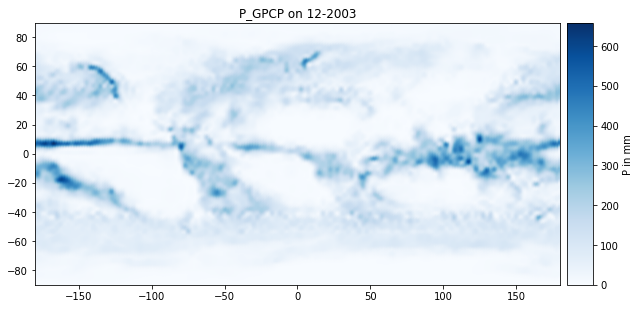

In [4]:
month='12'
year='2003'

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

norm,cmap=define_cmap(hydro_var_name,hydro_grid,year,month)
fig, ax = plt.subplots(figsize=(10,5))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='black')
hydro_grid.plot(ax=ax,marker='.',column='{} {}-{}-15'.format(hydro_var_name,year,month),
             legend=True,legend_kwds={'label': "{} in mm".format(hydro_var_name)},cax=cax,
            cmap=cmap,norm=norm,
               missing_kwds={"color": "grey",}
               )
#basins.plot(ax=ax,edgecolor='green',alpha=0.3,linewidth=0.5)
ax.set_facecolor("grey")
ax.set_xlim([-180,180])
ax.set_ylim([-90,90])
ax.set_title('{}_{} on {}-{}'.format(hydro_var_name,data,month,year))
#plt.savefig('../plots/hydrology/{}_{}_world_{}_{}.png'.format(hydro_var_name,data,month,year))
plt.show()

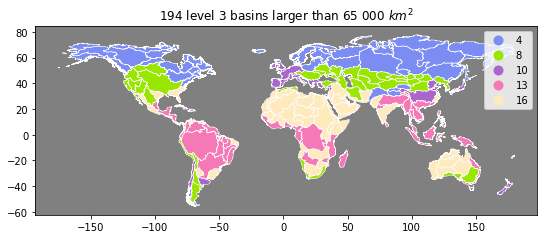

In [24]:
fig, ax = plt.subplots(figsize=(9,5))
ax.set_aspect('equal')
basins.plot(ax=ax,edgecolor='white',linewidth=0.5,column='CLIMATE',categorical=True,
            cmap=ListedColormap([climate_colors[i-1] for i in np.unique(basins['CLIMATE'])]),
                  legend=True)
ax.set_facecolor("grey")
ax.set_title('{} level 3 basins larger than 65 000 $km^2$'.format(basins.shape[0]))
plt.show()

# 2. Hydrological variables in a given basin

## Basin selection

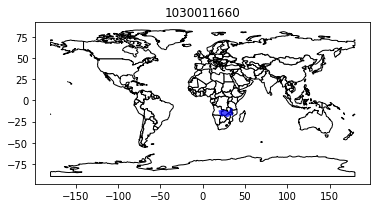

In [6]:
basin_id=basins.index[np.random.randint(basins.shape[0])]

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots()
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
basins.loc[[basin_id],'geometry'].plot(ax=ax, color='blue',alpha=0.7)
plt.title(basin_id)
plt.show()

To find the grid coordinates loacted inside a given basin, we rely on R-trees (__[reference](https://automating-gis-processes.github.io/site/notebooks/L3/spatial_index.html)__) in the function `find_coordinates_inside_basin`. The method is the following : 

1. we compare the bounds of the Polygon into the spatial index of the Points. This gives us point candidates that are likely to be within the Polygon (at this stage based on the MBR of the points that is stored inside the R-tree). 

1. we go through the candidate points and make a normal spatial intersection query that gives us the accurate results

In [11]:
#my_basin=basins.loc[[basin_id],'geometry']
#final_selection=find_coordinates_inside_basin(my_basin,spatial_grid,basins)
#hydro_basin=hydro_grid.loc[final_selection.index]

Results of the spatial selection are saved to reduce computational time.

In [7]:
my_basin=basins.loc[[basin_id],'geometry']
final_selection=geopandas.read_file("../datasets/hydroATLAS_basins_grid/{}.shp".format(basin_id))
final_selection.set_index(pd.MultiIndex.from_frame(final_selection[['x','y']]),inplace=True)

hydro_grid.set_index(pd.MultiIndex.from_frame(hydro_grid[['x','y']]),inplace=True)
hydro_basin=final_selection.join(hydro_grid.loc[:,['{} {}'.format(hydro_var_name,d.date()) for d in time_hydro]])
hydro_basin.set_index(np.arange(hydro_basin.shape[0]),inplace=True)

## Missing values

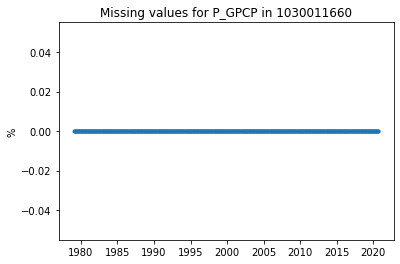

In [8]:
nb_missing_values=hydro_basin.loc[:,['{} {}'.format(hydro_var_name,d.date()) for d in time_hydro]].isna().sum()
perc_missing_values=100*nb_missing_values/final_selection.shape[0]
plt.figure()
plt.plot(time_hydro,perc_missing_values,'.')
plt.title("Missing values for {}_{} in {}".format(hydro_var_name,data,basin_id))
plt.ylabel('%')
plt.show()

If needed, we reconstruct temporal missing values with interpolation (cubic by default) and spatial missing values with at least two neighbours

In [37]:
hydro_basin,filling=my_fillna(hydro_basin,hydro_var_name,time_hydro,data,version=version_data[data])
filling

False

c:\users\fafal\miniconda3\lib\site-packages\geopandas\plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


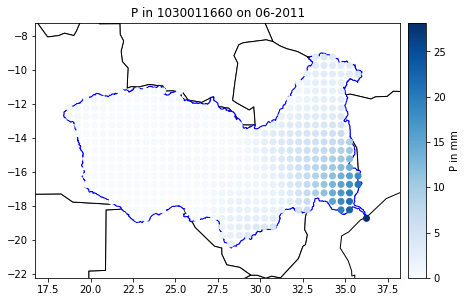

In [9]:
year=2011
month='06'

norm,cmap=define_cmap(hydro_var_name,hydro_basin,year,month)

fig, ax = plt.subplots(figsize=(7,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='black')
#my_basin.plot(ax=ax, color='white', edgecolor='black')
my_basin.plot(ax=ax, color='white',edgecolor='blue')
hydro_basin.plot(ax=ax,column='{} {}-{}-15'.format(hydro_var_name,year,month),
             legend=True,legend_kwds={'label': "{} in mm".format(hydro_var_name)},cax=cax,
                 missing_kwds={"color": "red",},
            cmap=cmap,norm=norm)
ax.set_xlim([hydro_basin.x.min()-2,hydro_basin.x.max()+2])
ax.set_ylim([hydro_basin.y.min()-2,hydro_basin.y.max()+2])
ax.set_title('{} in {} on {}-{}'.format(hydro_var_name,basin_id,month,year))
plt.show()

## Spatial averaging

In [10]:
hydro_mean_basin, hydro_mean_basin_filter=hydrological_variables_basin_filtered(hydro_basin,hydro_var_name,
                                                                time_hydro,data,version=version_data[data])

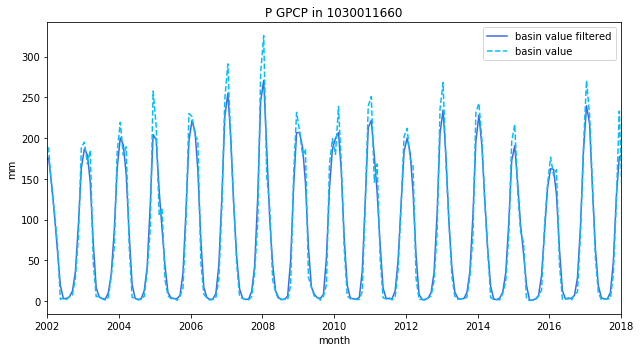

In [11]:
plt.figure(figsize=(9,5))
if hydro_var_name=='TWS': # filtered and unfiltered variables are the same for water storage CHANGES
    plt.plot(time_hydro.iloc[:183],hydro_mean_basin.iloc[:183],'k',label='basin value')
    non_missing_times=pd.to_datetime(perc_missing_values.iloc[:183].loc[perc_missing_values!=100].index.str[4:])
    plt.plot(non_missing_times,hydro_mean_basin.iloc[:183].loc[perc_missing_values!=100],
             'ko',label='observations')
    missing_times=pd.to_datetime(perc_missing_values.iloc[:183].loc[perc_missing_values==100].index.str[4:])
    plt.plot(missing_times,hydro_mean_basin.iloc[:183].loc[perc_missing_values==100],
             'x',color='grey',label='missing data')
else:
    plt.plot(time_hydro[1:-1],hydro_mean_basin_filter,label='basin value filtered',color='royalblue')
    plt.plot(time_hydro,hydro_mean_basin,'--',label='basin value',color='deepskyblue')
plt.legend()
plt.xlim([date(2002,1,1),date(2018,1,1)])
plt.xlabel("month")
plt.ylabel("mm")
plt.title("{} {} in {}".format(hydro_var_name,data,basin_id))
plt.tight_layout()
plt.show()

# 3. Water budget in a basin

In [12]:
basins=load_basins_data()

In [13]:
basin_id=basins.index[np.random.randint(basins.shape[0])]

data_P='ERA5_Land'
data_ET='ERA5_Land'
data_R='ERA5_Land'
data_TWS='GRACE_JPL_mascons'

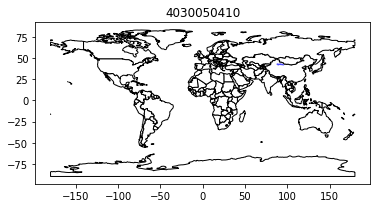

In [14]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots()
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
basins.loc[[basin_id],'geometry'].plot(ax=ax, color='blue',alpha=0.7)
plt.title(basin_id)
plt.show()

In [15]:
TWS_month=pd.read_csv('../results/hydrology/TWS_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
time_TWS=pd.to_datetime(TWS_month.columns.str[4+len(data_TWS):])

P_month=pd.read_csv('../results/hydrology/P_{}_monthly_filtered.csv'.format(data_P),index_col=[0])
time_P=pd.to_datetime(P_month.columns.str[2+len(data_P):])

ET_month=pd.read_csv('../results/hydrology/ET_{}_monthly_filtered.csv'.format(data_ET),index_col=[0])
time_ET=pd.to_datetime(ET_month.columns.str[3+len(data_ET):])

R_month=pd.read_csv('../results/hydrology/R_{}_monthly_filtered.csv'.format(data_R),index_col=[0])
time_R=pd.to_datetime(R_month.columns.str[2+len(data_R):]) 

time_idx=pd.date_range(max(time_P.min(),time_ET.min(),time_R.min(),time_TWS.min()),
       min(time_P.max(),time_ET.max(),time_R.max(),time_TWS.max()),
      freq='SM')[::2]

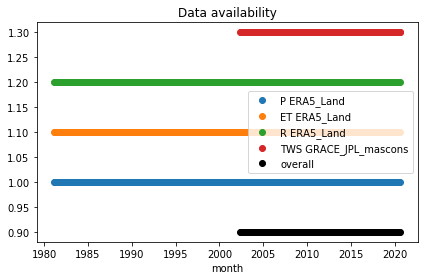

In [16]:
plt.figure()
plt.plot(time_P.values,[1]*time_P.shape[0],'o',label='P {}'.format(data_P))
plt.plot(time_ET.values,[1.1]*time_ET.shape[0],'o',label='ET {}'.format(data_ET))
plt.plot(time_R.values,[1.2]*time_R.shape[0],'o',label='R {}'.format(data_R))
plt.plot(time_TWS.values,[1.3]*time_TWS.shape[0],'o',label='TWS {}'.format(data_TWS))
plt.plot(time_idx.values,[0.9]*time_idx.shape[0],'ko',label='overall')
plt.legend()
plt.title("Data availability")
plt.xlabel("month")
plt.tight_layout()
plt.show()

In [17]:
P_filter=P_month.loc[basin_id,['P_{} {}'.format(data_P,d.date()) for d in time_idx]]
ET_filter=ET_month.loc[basin_id,['ET_{} {}'.format(data_ET,d.date()) for d in time_idx]]
R_filter=R_month.loc[basin_id,['R_{} {}'.format(data_R,d.date()) for d in time_idx]]
TWSC_filter=TWS_month.loc[basin_id,['TWS_{} {}'.format(data_TWS,d.date()) for d in time_idx]]

fillingP=(np.sum(np.isnan(P_filter))==0)
fillingET=(np.sum(np.isnan(ET_filter))==0)
fillingR=(np.sum(np.isnan(R_filter))==0)
fillingTWS=(np.sum(np.isnan(TWSC_filter))==0)

if fillingP&fillingET&fillingR&fillingTWS: # if this basin is entirely covered by all datasets, proceed, otherwise the loop ends
    A_filter=pd.Series(P_filter.values-ET_filter.values-R_filter.values,index=time_idx)
else:
    print('This basin is not entirely covered')

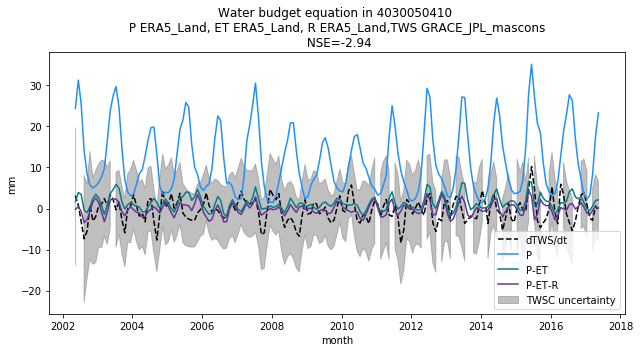

In [18]:
plot_water_budget_details(TWSC_filter,P_filter,ET_filter,R_filter,time_idx[:181],
                          basin_id,data_P,data_ET,data_R,data_TWS,figsize=(9,5))

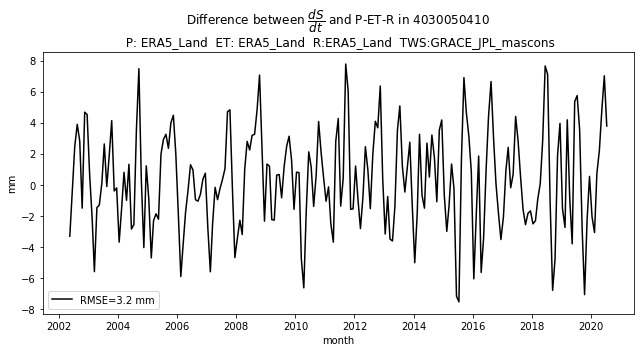

In [19]:
TWSC_series=pd.Series(TWSC_filter.values,index=time_idx)

plt.figure(figsize=(9,5))
plt.plot(A_filter-TWSC_series,'k',
         label='RMSE={:.1f} mm'.format(compute_RMSE(A_filter,TWSC_series))
         #label='mean={:.1f} mm' .format(np.mean(A_filter-pd.Series(TWSC_filter.values,index=time_idx)))
        )
plt.ylabel('mm')
plt.xlabel('month')
plt.title('Difference between $\dfrac{dS}{dt}$ and P-ET-R'+' in {} \n P: {}  ET: {}  R:{}  TWS:{}'.format(basin_id,
                                                    data_P,data_ET,data_R,data_TWS))
plt.legend()
plt.tight_layout()
plt.show()

# 4. Compare datasets

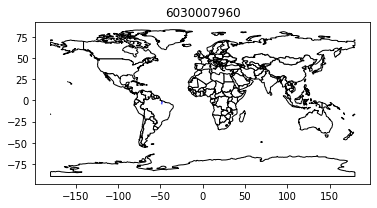

In [20]:
basins=load_basins_data()

basin_id=basins.index[np.random.randint(basins.shape[0])]

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots()
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
basins.loc[[basin_id],'geometry'].plot(ax=ax, color='blue',alpha=0.7)
plt.title(basin_id)
plt.show()

In [21]:
hydro_var_name='ET'
#list_data=['GLDAS20_VIC412','GLDAS21_VIC412','ERA5_Land']
list_data=['ERA5_Land','GLDAS20_CLSM25','GLDAS21_CLSM25','GLEAM']

In [137]:
hydro_var_name='P'
list_data=['GPCC','GPCP','GPM']
#list_data=['GPCP','ERA5_Land','MSWEP']

In [139]:
hydro_var_name='R'
list_data=['GLDAS20_VIC412','GLDAS21_VIC412','GRUN']
#list_data=['MERRA2','GRUN','GLDAS21_CLSM25']

In [76]:
hydro_var_name='TWS'
list_data=['GRACE_JPL_mascons','GRACE_CSR_mascons','GRACE_CSR_grid','GRACE_ITSG_grid']

In [41]:
hydro_var_name='PET'
list_data=['SSEBop','CRU','GLEAM']

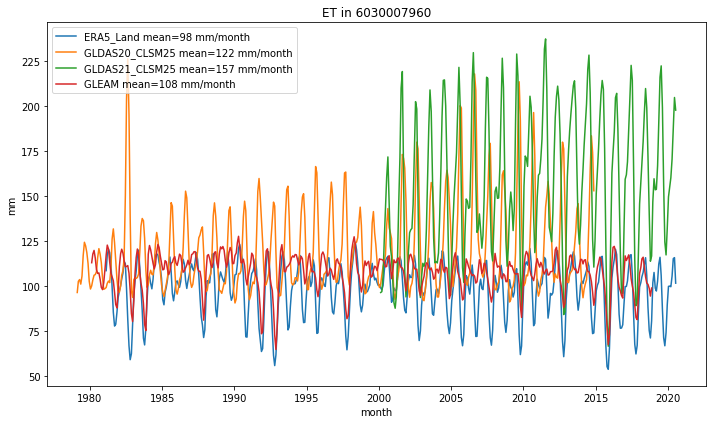

In [22]:
plt.figure(figsize=(10,6))

for data in list_data:
    hydro_month=pd.read_csv('../results/hydrology/{}_{}_monthly_filtered.csv'.format(hydro_var_name,data),
                                                            index_col=[0])
    time_hydro=pd.to_datetime(hydro_month.columns.str[len(hydro_var_name)+1+len(data):])
    plt.plot(time_hydro,hydro_month.loc[basin_id],label='{} mean={:.0f} mm/month'.format(data,hydro_month.loc[basin_id].mean()))
plt.legend(loc='upper left')
plt.title("{} in {}".format(hydro_var_name,basin_id))
plt.xlabel('month')
plt.ylabel("mm")
#plt.xlim([date(2002,5,1),date(2017,7,1)])
plt.tight_layout()
plt.show()    

# 5. Datasets availability

In [23]:
list_data_P=['CPC','MERRA2','MSWEP','TRMM','CRU','GPCP']
list_data_ET=['MERRA2','SSEBop','GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412','GLEAM']
list_data_PET=['SSEBop','CRU','GLEAM']
list_data_R=['GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412','GRUN','MERRA2']
list_data_TWS=['GRACE_CSR_mascons','GRACE_JPL_mascons','GRACE_CSR_grid']

list_data={'P':list_data_P,
          'ET':list_data_ET,
          'R':list_data_R,
          'TWS':list_data_TWS}

In [38]:
spatial_grid.shape[0]

64800

<IPython.core.display.Javascript object>


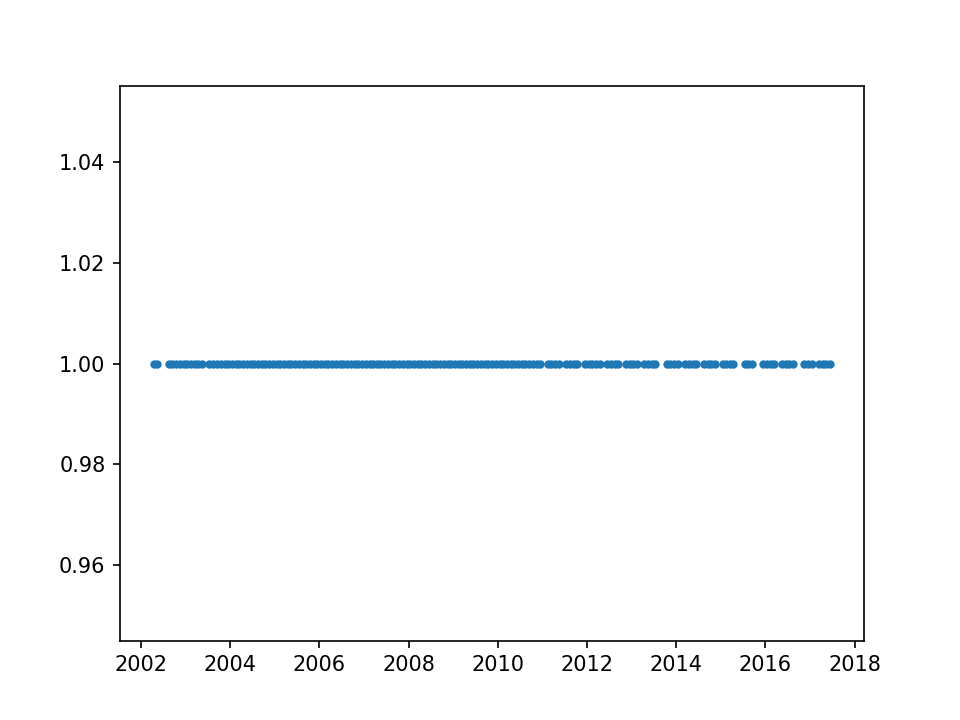

In [51]:
to_plot=time_hydro.copy()
to_plot[np.where(np.sum(np.isnan(hydro_grid.iloc[:,3:]))==spatial_grid.shape[0])[0]]=np.nan

plt.figure()
plt.plot(to_plot,np.ones_like(to_plot,dtype=float),'.')
plt.show()

<IPython.core.display.Javascript object>


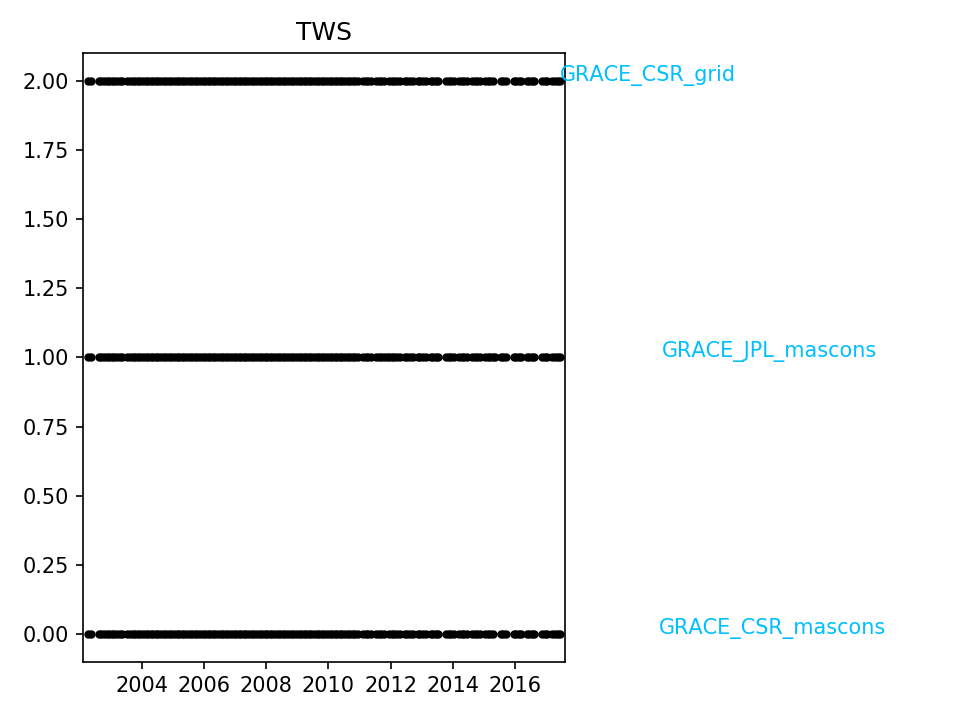

In [56]:
plt.figure()
list_markers=['o','v','s','*','x','d','+']

hydro_var_name='TWS'
for i,data in enumerate(list_data_TWS):
    (spatial_grid,hydro_grid,time_hydro)=load_hydro_data(hydro_var_name,data,
                                fill_value=dict_fill_value[data],version=version_data[data])
    
    to_plot=time_hydro.copy()
    to_plot[np.where(np.sum(np.isnan(hydro_grid.iloc[:,3:]))==spatial_grid.shape[0])[0]]=np.nan
    plt.plot(to_plot,i*np.ones_like(to_plot,dtype=float),color=dict_color[hydro_var_name],marker='.',label=data)

    #plt.plot(time_hydro[::12],i*np.ones_like(time_hydro[::12],dtype=float),color='deepskyblue',marker=list_markers[i],label=data)
    plt.text(time_hydro.iloc[-1],i,data,c='deepskyblue')
plt.xlim([date(2002,4-2,15),date(2017,6+2,15)])
plt.title(hydro_var_name)
plt.tight_layout()
plt.show()    

In [28]:
dict_color={'P':'deepskyblue','ET':'teal','R':'rebeccapurple','TWS':'black'}

<IPython.core.display.Javascript object>


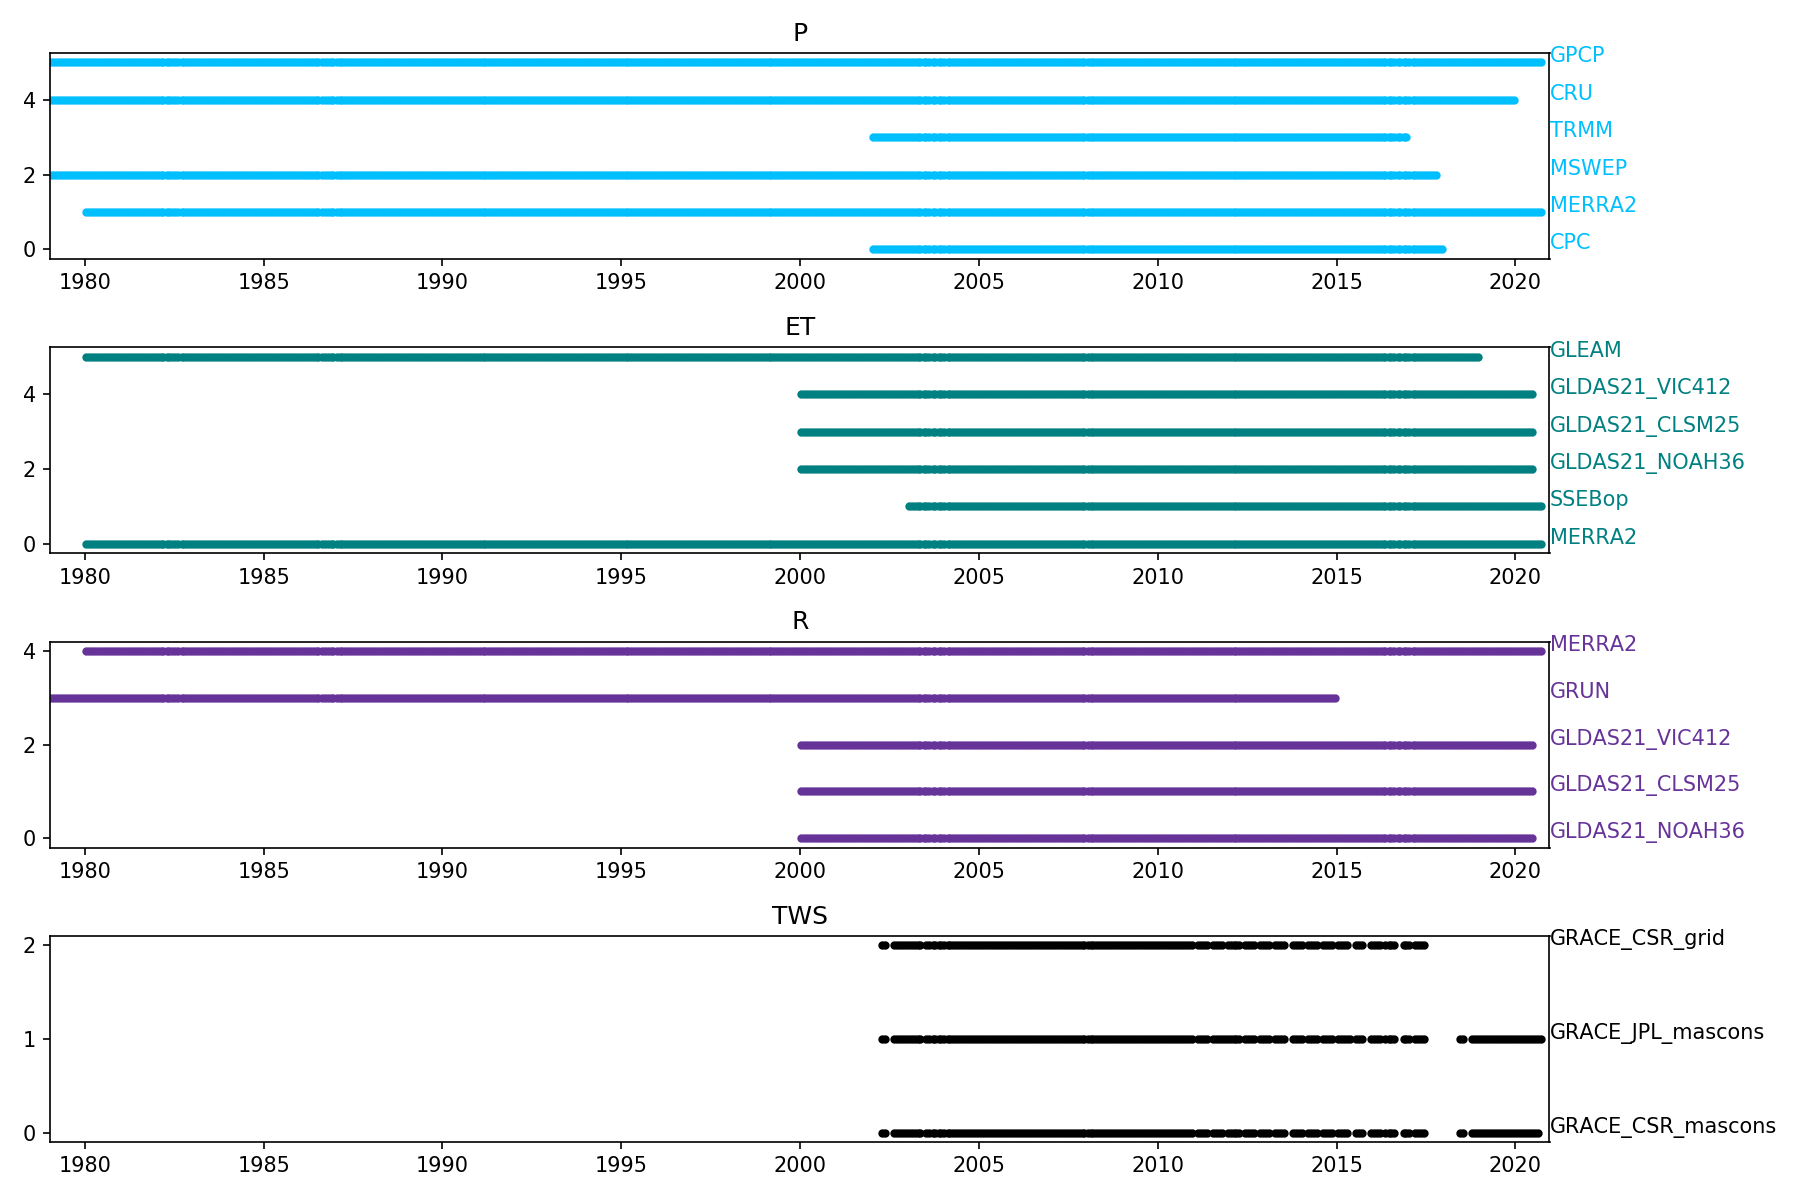

In [58]:
plt.figure(figsize=(12,8))

for nplot,hydro_var_name in enumerate(['P','ET','R','TWS']):
    plt.subplot(4,1,nplot+1)
    for i,data in enumerate(list_data[hydro_var_name]):
        (spatial_grid,hydro_grid,time_hydro)=load_hydro_data(hydro_var_name,data,
                                    fill_value=dict_fill_value[data],version=version_data[data])
        to_plot=time_hydro.copy()
        to_plot[np.where(np.sum(np.isnan(hydro_grid.iloc[:,3:]))==spatial_grid.shape[0])[0]]=np.nan
        plt.plot(to_plot,i*np.ones_like(to_plot,dtype=float),color=dict_color[hydro_var_name],marker='.',label=data)
        #plt.plot(time_hydro[::12],i*np.ones_like(time_hydro[::12],dtype=float),color=dict_color[hydro_var_name],marker=list_markers[i],label=data)
        plt.text(date(2020,12,15),i,data,c=dict_color[hydro_var_name])
    plt.xlim([date(1979,1,15),date(2020,12,15)])
    plt.title(hydro_var_name)
plt.tight_layout()
plt.show()    